## g:profiler enrichment analysis evaluation 

updated the gene name. 

1.  default setting pick the lowest p val when it pass both coverage and pval threshold as best term, then filter by coverage for both LLM and enrichment 
    
2. pick the smallest p val and remove the coverage requirment for both

    a. pick the smallest p, then add coverage requirement 

    b. pick the smallest p , then add JI requirement

3. pick best coverage among the ones passing both coverage and pval threshold, then filter by coverage 

4. use semantic similarity to find closest GO term as LLM name (in separate notebook), then use JI for picking best term and filtering 

    


In [6]:
LLM_score_thresh = 0.01 # only drop the ones LLM does not assign a name 
adj_pval_thresh = 0.05
JI_thresh = 0.05
coverage_thresh = 0.2

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7, 'font.family': 'sans-serif'})
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['axes.titlesize'] = 7

from utils.analyze_enrichment_utils import *
%load_ext autoreload
%autoreload 2

### Data files from other analyses:
 - inputfile: LLM analyzed + gProfiler enrichment analysis on updated gene symbols
 - LLM coverage analysis - used GPT-4 to review the analysis text to determine which genes met the criteria that they are "definite" supports, not conjecture.
 - Best matching GO terms to LLM names, used to estimate how many genes match the name, enabling the computation of a JI

In [8]:

import pandas as pd
from utils.analyze_enrichment_utils import cal_JI_coverage

group_col = ["Source", "GeneSetID", "GeneSetName", "GeneList"] # group by these columns in future steps

## input file: LLM analyzed + gProfiler enrichment
updated_name_llm_file = 'data/omics_revamped_LLM_gprofiler_new_gene_name_DF.tsv'
# Read the TSV file into a Pandas DataFrame
LLM_genes_DF = pd.read_csv(updated_name_llm_file, delimiter="\t")
# make sure intersection_size, term_size, query_size are integers
LLM_genes_DF['intersection_size'] = LLM_genes_DF['intersection_size'].apply(lambda x: int(x))
LLM_genes_DF['term_size'] = LLM_genes_DF['term_size'].apply(lambda x: int(x))
LLM_genes_DF['query_size'] = LLM_genes_DF['query_size'].apply(lambda x: int(x))
#LLM_genes_DF.shape
LLM_genes_DF = cal_JI_coverage(LLM_genes_DF)
LLM_genes_DF.head(1)

,Source,GeneSetID,GeneSetName,GeneList,updated GeneList,n_Genes,LLM Name,LLM Analysis,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,query_size,intersections,gprofiler_JI,gprofiler_coverage
0,NeST,Cluster1-10,Cluster1-10,CTRL HSD17B14 KIAA0232 PAQR8 PLA2G1B RNF145 SG...,CTRL HSD17B14 KIAA0232 PAQR8 PLA2G1B RNF145 SG...,12,Lipid Metabolism and Membrane Dynamics,"1. CTRL, or carboxyl-terminal esterase/lipase,...",0.85,L-leucine import across plasma membrane,GO:1903801,0.080467,1,5,10,SLC7A8,0.071429,0.1


In [9]:
## load the LLM coverage data as a common df to merge
llm_coverage_df = pd.read_csv("data/omics_revamped_LLM_Enrichr_simVals_new_genecounts_DF.tsv", sep="\t")[['Source','GeneSetID',
                'GeneSetName', 'GeneList', 'n_Genes', 
                'Supporting Genes','Supporting Count','LLM Support Analysis','GenesMentionedInText', 'LLM_coverage']]

llm_JI_file = 'data/omics_revamped_LLM_w_best_matching_GO_terms_for_JI.tsv'
llm_ji_df = pd.read_csv(llm_JI_file, sep="\t")

In [10]:
# merge with the LLM coverage data
merged_genes_DF = pd.merge(LLM_genes_DF, llm_coverage_df, on=['Source','GeneSetID','GeneSetName', 'GeneList', 'n_Genes'], how='left')
print(merged_genes_DF.shape)
# print(merged_genes_DF.columns)


# merge with the LLM JI data

merged_genes_DF = pd.merge(merged_genes_DF, llm_ji_df, on=['Source','GeneSetID','GeneList','n_Genes', 'LLM Name','Supporting Count'], how='left')
print(merged_genes_DF.shape)
print(merged_genes_DF.columns)

(53452, 23)
(53452, 28)
Index(['Source', 'GeneSetID', 'GeneSetName', 'GeneList', 'updated GeneList',
       'n_Genes', 'LLM Name', 'LLM Analysis', 'Score', 'Term', 'GO ID',
       'Adjusted P-value', 'intersection_size', 'term_size', 'query_size',
       'intersections', 'gprofiler_JI', 'gprofiler_coverage',
       'Supporting Genes', 'Supporting Count', 'LLM Support Analysis',
       'GenesMentionedInText', 'LLM_coverage', 'LLM_best_matching_GO',
       'best_matching_GO_ID', 'best_matching_GO_term_genes',
       'best_matching_GO_term_size', 'LLM_JI'],
      dtype='object')


# 1. Best APV that also passes coverage threshold

 - Select the best GO term by the smallest p-value among the terms passing the p-value and coverage threshold. 
 - Filter by both p-value and coverage threshold to determine success vs not. 

However, there may be multiple GO terms with the smallest p-value and this procedure returns the one that is first in the list. 

This means that in a significant number of cases, the selected GO term will *not* have the best coverage.

In [43]:
from utils.analyze_enrichment_utils import filter_and_select_coverage, create_success_contingency_table, select_rows_and_columns

input_df = merged_genes_DF.copy()

# Grouping the DataFrame by the specified columns
grouped = input_df.groupby(group_col)

# Apply the function to each group and reset the index
reduced_LLM_genes_by_coverage_DF = grouped.apply(lambda x: filter_and_select_coverage(x, coverageCol = 'gprofiler_coverage', thresh = coverage_thresh, adj_pval_thresh=adj_pval_thresh)).reset_index(drop=True)

# reset LLM_success_TF and gprofiler_success_TF
reduced_LLM_genes_by_coverage_DF['LLM_success_TF'] = False
reduced_LLM_genes_by_coverage_DF['gprofiler_success_TF'] = False

# Add the 'LLM_success_TF' and 'gprofiler_success_TF' columns
reduced_LLM_genes_by_coverage_DF['LLM_success_TF'] = ((reduced_LLM_genes_by_coverage_DF['Score'] >= LLM_score_thresh) & (reduced_LLM_genes_by_coverage_DF['LLM_coverage'] >= coverage_thresh)) # LLM creteria
reduced_LLM_genes_by_coverage_DF['gprofiler_success_TF'] = ((reduced_LLM_genes_by_coverage_DF['Adjusted P-value'] <= adj_pval_thresh) & (reduced_LLM_genes_by_coverage_DF['gprofiler_coverage'] >= coverage_thresh)) # enrichment criteria

print(create_success_contingency_table(reduced_LLM_genes_by_coverage_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_by_coverage_DF, 5)
result_df

LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                   103    113    216
False                    9     75     84
Total                  112    188    300


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,cellular catabolic process,GO:0044248,0.010811,8,1600,"S100A8,TWIST1,VIM,CLU,TENT5A,MAOB,SLC27A2,ZBTB20",0.363636,0.21,0.004957,True,True
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,defense response,GO:0006952,0.001123,15,1791,"1060P11.3,ADM,CAV2,CDC42EP3,CHST1,EMP1,IGF2BP3...",0.340909,0.13,0.008242,False,True
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,response to chemical,GO:0042221,0.005933,24,3957,"ABAT,ASS1,CHI3L1,CLDN3,GAL,PDE8B,TRD,TYMP,1060...",0.452830,NaN,0.006021,False,True
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of oligodendrocyte apoptotic process,GO:1900141,0.000143,2,2,"GAS6,AKAP12",0.222222,NaN,0.222222,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,cellular response to interleukin-1,GO:0071347,0.000712,4,106,"H2AC6,IL1R2,NUP93,SOX9",0.285714,NaN,0.034483,False,True


In [36]:
# Save the DataFrame to a TSV file
reduced_LLM_genes_by_coverage_DF.to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_DF_coverage_thresh.tsv", sep="\t", index=False)

Because we picked the best GO term by the smallest p-value among the terms passing the p-value and coverage threshold, it means that changing the coverage threshold will change the curve. 

This g:Profiler curve is based on GO terms picked by setting the coverage threshold at 0.2. If we pick a **different** threshold, then the curve will change

coverage threshold: 0.0, enrichment: 229.0, LLM: 135.0
coverage threshold: 0.2, enrichment: 216.0, LLM: 112.0
coverage threshold: 0.5, enrichment: 76.0, LLM: 64.0


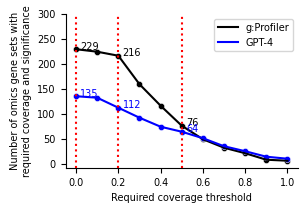

In [44]:
## plot coverage threshold curve
from utils.analyze_enrichment_utils import plot_thresholding_res
%reload_ext autoreload
%autoreload 2

save_plot_dir = 'data/omics_revamped_LLM_gprofiler_new_gene_name_DF_coverage_thresh_coverage_curve.svg'
plot_thresholding_res(reduced_LLM_genes_by_coverage_DF, 
                      'gprofiler_coverage', 
                      'LLM_coverage',coverage_thresh_list = np.arange(0.0, 1.1, 0.1), 
                      enrich_adj_pval_thresh = adj_pval_thresh, 
                      LLM_score_thresh = LLM_score_thresh, 
                      highlight_coverage = [0.0, 0.2, 0.5])


# 2. Best APV

 - Select the best GO by the smallest p-value
 - Filter by p-value. 

If we later apply a coverage threshold to generate this curve, the curve will not change if the threshold is changed because the enriched term is not picked based on the coverage threshold

In [37]:
from utils.analyze_enrichment_utils import get_min_adj_p_value
%reload_ext autoreload
%autoreload 2

coverage_thresh = 0.2

# Grouping the DataFrame by the specified columns
grouped = merged_genes_DF.groupby(group_col)

# Apply the function to each group and reset the index
reduced_LLM_genes_APV_only_DF = grouped.apply(get_min_adj_p_value).reset_index(drop=True)


# Add the 'LLM_success_TF' and 'gprofiler_success_TF' columns
reduced_LLM_genes_APV_only_DF['LLM_success_TF'] = ((reduced_LLM_genes_APV_only_DF['Score'] >= LLM_score_thresh))
reduced_LLM_genes_APV_only_DF['gprofiler_success_TF'] = ~((reduced_LLM_genes_APV_only_DF['Adjusted P-value'] > adj_pval_thresh)) # enrichment criteria

print(create_success_contingency_table(reduced_LLM_genes_APV_only_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_APV_only_DF, 5)
result_df


LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                   124    105    229
False                   11     60     71
Total                  135    165    300


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,collagen metabolic process,GO:0032963,0.005761,4,101,"COL5A1,MMP2,VIM,CST3",0.181818,0.21,0.033613,True,True
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,defense response,GO:0006952,0.001123,15,1791,"1060P11.3,ADM,CAV2,CDC42EP3,CHST1,EMP1,IGF2BP3...",0.340909,0.13,0.008242,True,True
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,response to chemical,GO:0042221,0.005933,24,3957,"ABAT,ASS1,CHI3L1,CLDN3,GAL,PDE8B,TRD,TYMP,1060...",0.452830,NaN,0.006021,False,True
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of oligodendrocyte apoptotic process,GO:1900141,0.000143,2,2,"GAS6,AKAP12",0.222222,NaN,0.222222,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,cellular response to interleukin-1,GO:0071347,0.000712,4,106,"H2AC6,IL1R2,NUP93,SOX9",0.285714,NaN,0.034483,False,True


coverage threshold: 0.0, enrichment: 229.0, LLM: 135.0
coverage threshold: 0.2, enrichment: 163.0, LLM: 112.0
coverage threshold: 0.5, enrichment: 69.0, LLM: 64.0


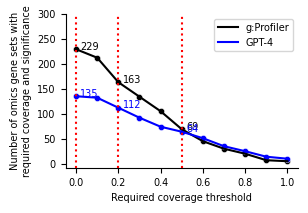

In [38]:
# plot thresholding curve
from utils.analyze_enrichment_utils import plot_thresholding_res
%reload_ext autoreload
%autoreload 2
save_plot_dir = 'data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_only_coverage_curve.svg'
plot_thresholding_res(reduced_LLM_genes_APV_only_DF, 'gprofiler_coverage', 'LLM_coverage',coverage_thresh_list = np.arange(0.0, 1.1, 0.1), enrich_adj_pval_thresh = adj_pval_thresh, LLM_score_thresh = LLM_score_thresh, highlight_coverage = [0.0, 0.2, 0.5])

In [ ]:
# save 
reduced_LLM_genes_APV_only_DF.to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_only.tsv", sep="\t", index=False)

# 2.1 Best APV with highest coverage

 - Select the best GO term by the smallest p-value
 -- If there are multiple GO terms with the same smallest p-value, then select the term with the highest coverage.
 - Filter by both the p-value and coverage thresholds. 


In [11]:
from utils.analyze_enrichment_utils import get_min_adj_p_value
%reload_ext autoreload
%autoreload 2

coverage_thresh = 0.2

# Grouping the DataFrame by the specified columns
grouped = merged_genes_DF.groupby(group_col)

# Apply the function to each group and reset the index
reduced_LLM_genes_APV_cover_thresh_DF = grouped.apply(lambda x: get_min_adj_p_value(x, sortCol='gprofiler_coverage')).reset_index(drop=True)


# Add the 'LLM_success_TF' and 'gprofiler_success_TF' columns
reduced_LLM_genes_APV_cover_thresh_DF['LLM_success_TF'] = ((reduced_LLM_genes_APV_cover_thresh_DF['Score'] >= LLM_score_thresh)& (reduced_LLM_genes_APV_cover_thresh_DF['LLM_coverage'] >= coverage_thresh)) # LLM creteria
reduced_LLM_genes_APV_cover_thresh_DF['gprofiler_success_TF'] = ~((reduced_LLM_genes_APV_cover_thresh_DF['Adjusted P-value'] > adj_pval_thresh) | (reduced_LLM_genes_APV_cover_thresh_DF['gprofiler_coverage'] < coverage_thresh)) # enrichment criteria


print(create_success_contingency_table(reduced_LLM_genes_APV_cover_thresh_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_APV_cover_thresh_DF, 5)
result_df


LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                    96     91    187
False                   16     97    113
Total                  112    188    300


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,collagen metabolic process,GO:0032963,0.005761,4,101,"COL5A1,MMP2,VIM,CST3",0.181818,0.21,0.033613,True,False
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,response to stress,GO:0006950,0.001123,22,3855,"1060P11.3,ADM,CAV2,CDC42EP3,CHST1,EMP1,EXT1,NI...",0.500000,0.13,0.005674,False,True
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,developmental process,GO:0032502,0.005933,32,6453,"ABAT,ASS1,CHI3L1,CLDN3,FRZB,GAL,MAN2A1,NELL2,T...",0.603774,NaN,0.004943,False,True
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of oligodendrocyte apoptotic process,GO:1900141,0.000143,2,2,"GAS6,AKAP12",0.222222,NaN,0.222222,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,cellular response to interleukin-1,GO:0071347,0.000712,4,106,"H2AC6,IL1R2,NUP93,SOX9",0.285714,NaN,0.034483,False,True


coverage threshold: 0.0, enrichment: 229.0, LLM: 135.0
coverage threshold: 0.2, enrichment: 187.0, LLM: 112.0
coverage threshold: 0.5, enrichment: 86.0, LLM: 64.0


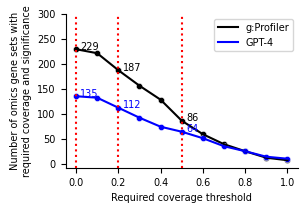

In [12]:
# plot
from utils.analyze_enrichment_utils import plot_thresholding_res
%reload_ext autoreload
%autoreload 2
save_plot_dir = 'data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_cover_thresh_coverage_curve.svg'
plot_thresholding_res(reduced_LLM_genes_APV_cover_thresh_DF, 'gprofiler_coverage', 'LLM_coverage',coverage_thresh_list = np.arange(0.0, 1.1, 0.1), enrich_adj_pval_thresh = adj_pval_thresh, LLM_score_thresh = LLM_score_thresh, highlight_coverage = [0.0, 0.2, 0.5])

In [15]:
# # save the file
# reduced_LLM_genes_APV_cover_thresh_DF.to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_cover_thresh_02.tsv", sep="\t", index=False)
# # save the T/F, F/T and T/T separately
# reduced_LLM_genes_APV_cover_thresh_DF[(reduced_LLM_genes_APV_cover_thresh_DF['LLM_success_TF'] == True) & (reduced_LLM_genes_APV_cover_thresh_DF['gprofiler_success_TF'] == False)].to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_cover_thresh_02_llmT_goF.tsv", sep="\t", index=False)
# reduced_LLM_genes_APV_cover_thresh_DF[(reduced_LLM_genes_APV_cover_thresh_DF['LLM_success_TF'] == False) & (reduced_LLM_genes_APV_cover_thresh_DF['gprofiler_success_TF'] == True)].to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_cover_thresh_02_llmF_goT.tsv", sep="\t", index=False)

# # Calculated semantic similarity between LLM and gprofiler gene names by running "run_omics_sem_sim.py"
# # load the file with semantic similarity 
# sim_val_reduce_LLM_gnees_APV_cover_thresh_DF = pd.read_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_cover_thresh_02_simVals_DF.tsv", sep="\t")
# #sort 
# sim_val_reduce_LLM_gnees_APV_cover_thresh_DF.sort_values(by='LLM_name_GO_term_sim', ascending=False, inplace=True)
# sim_val_reduce_LLM_gnees_APV_cover_thresh_DF[(sim_val_reduce_LLM_gnees_APV_cover_thresh_DF['LLM_success_TF'] == True) & (sim_val_reduce_LLM_gnees_APV_cover_thresh_DF['gprofiler_success_TF'] == True)].to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_cover_thresh_02_llmT_goT.tsv", sep="\t", index=False)

# 2.2 Best APV with highest JI
 - Select the best GO term by the smallest p-value
 -  If there are multiple GO terms with the same smallest p-value, then pick the term with the highest JI.
 - Filter by both the p-value and JI thresholds.


In [24]:
from utils.analyze_enrichment_utils import get_min_adj_p_value
%reload_ext autoreload
%autoreload 2

# Grouping the DataFrame by the specified columns
grouped = merged_genes_DF.groupby(group_col)

# Apply the function to each group and reset the index
reduced_LLM_genes_APV_thred_JI_DF = grouped.apply(lambda x: get_min_adj_p_value(x, sortCol='gprofiler_JI')).reset_index(drop=True)


# Add the 'LLM_success_TF' and 'gprofiler_success_TF' columns
reduced_LLM_genes_APV_thred_JI_DF['LLM_success_TF'] = ((reduced_LLM_genes_APV_thred_JI_DF ['Score'] >= LLM_score_thresh)& (reduced_LLM_genes_APV_thred_JI_DF ['LLM_JI'] >= JI_thresh)) # LLM creteria
reduced_LLM_genes_APV_thred_JI_DF['gprofiler_success_TF'] = ~((reduced_LLM_genes_APV_thred_JI_DF ['Adjusted P-value'] > adj_pval_thresh) | (reduced_LLM_genes_APV_thred_JI_DF['gprofiler_JI'] < JI_thresh)) # enrichment criteria


print(create_success_contingency_table(reduced_LLM_genes_APV_thred_JI_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_APV_thred_JI_DF, 5)
result_df


LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                    11     22     33
False                   31    236    267
Total                   42    258    300


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,collagen metabolic process,GO:0032963,0.005761,4,101,"COL5A1,MMP2,VIM,CST3",0.181818,0.21,0.033613,False,False
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,inflammatory response,GO:0006954,0.001123,11,829,"1060P11.3,ADM,CAV2,CDC42EP3,EMP1,LPAR6,TRIB2,A...",0.250000,0.13,0.012761,False,False
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,actomyosin structure organization,GO:0031032,0.005933,6,204,"AKR1B1,CAPN3,DKK1,MARCKS,MTUS1,OPN3",0.113208,NaN,0.023904,False,False
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of oligodendrocyte apoptotic process,GO:1900141,0.000143,2,2,"GAS6,AKAP12",0.222222,NaN,0.222222,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,cellular response to interleukin-1,GO:0071347,0.000712,4,106,"H2AC6,IL1R2,NUP93,SOX9",0.285714,NaN,0.034483,False,False


coverage threshold: 0.0, enrichment: 229.0, LLM: 135.0
coverage threshold: 0.05, enrichment: 84.0, LLM: 62.0
coverage threshold: 0.1, enrichment: 33.0, LLM: 42.0


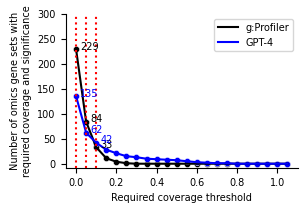

In [22]:
# plot thresholding curve
from utils.analyze_enrichment_utils import plot_thresholding_res
%reload_ext autoreload
%autoreload 2
save_plot_dir = 'data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_only_JI_thresh_curve.svg'
plot_thresholding_res(reduced_LLM_genes_APV_thred_JI_DF, 'gprofiler_JI', 'LLM_JI',coverage_thresh_list = np.arange(0.0, 1.1, 0.05), enrich_adj_pval_thresh = adj_pval_thresh, LLM_score_thresh = LLM_score_thresh, highlight_coverage = [0.0, 0.05,0.1])

In [ ]:
# # uncomment and save 
# reduced_LLM_genes_APV_thred_JI_DF.to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_JI_thresh_005.tsv", sep="\t", index=False)
# # save the T/F, F/T and T/T separately
# reduced_LLM_genes_APV_thred_JI_DF[(reduced_LLM_genes_APV_thred_JI_DF['LLM_success_TF'] == True) & (reduced_LLM_genes_APV_thred_JI_DF['gprofiler_success_TF'] == False)].to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_JI_thresh_005_llmT_goF.tsv", sep="\t", index=False)
# reduced_LLM_genes_APV_thred_JI_DF[(reduced_LLM_genes_APV_thred_JI_DF['LLM_success_TF'] == False) & (reduced_LLM_genes_APV_thred_JI_DF['gprofiler_success_TF'] == True)].to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_JI_thresh_005_llmF_goT.tsv", sep="\t", index=False)

# ### Calculated semantic similarity between LLM and gprofiler gene names by running "run_omics_sem_sim.py"
# sim_val_reduced_LLM_genes_APV_thred_JI_DF = pd.read_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_JI_thresh_005_simVals_DF.tsv", delimiter="\t")
# sim_val_reduced_LLM_genes_APV_thred_JI_DF.sort_values(by='LLM_name_GO_term_sim', ascending=False, inplace=True)

# sim_val_reduced_LLM_genes_APV_thred_JI_DF[(sim_val_reduced_LLM_genes_APV_thred_JI_DF['LLM_success_TF'] == True) & (sim_val_reduced_LLM_genes_APV_thred_JI_DF['gprofiler_success_TF'] == True)].to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_JI_thresh_005_llmT_goT.tsv", sep="\t", index=False)

# 3.  Best coverage of those passing the p-value and coverage thresholds
 - Select the best GO term by highest coverage among the terms passing the p-value and coverage thresholds
 - Filter by both p-value and coverage thresholds to determine success vs not.

*Yields the SAME numbers as option #1 but selects different GO terms (prioritize coverage)*


In [34]:
from utils.analyze_enrichment_utils import filter_and_select_max_coverage
%reload_ext autoreload
%autoreload 2

grouped = merged_genes_DF.groupby(group_col)
reduced_LLM_genes_by_max_coverage_DF = grouped.apply(lambda x:filter_and_select_max_coverage(x, adj_pval_thresh, thresh=coverage_thresh)).reset_index(drop=True)

# Add the 'LLM_success_TF' and 'gprofiler_success_TF' columns
reduced_LLM_genes_by_max_coverage_DF['LLM_success_TF'] = ((reduced_LLM_genes_by_max_coverage_DF['Score'] >= LLM_score_thresh)& (reduced_LLM_genes_by_max_coverage_DF['LLM_coverage'] >= coverage_thresh)) # LLM creteria
reduced_LLM_genes_by_max_coverage_DF['gprofiler_success_TF'] = ~((reduced_LLM_genes_by_max_coverage_DF['Adjusted P-value'] > adj_pval_thresh) | (reduced_LLM_genes_by_max_coverage_DF['gprofiler_coverage'] < coverage_thresh)) # enrichment criteria

print(create_success_contingency_table(reduced_LLM_genes_by_max_coverage_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_by_max_coverage_DF, 5)
result_df

LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                   103    113    216
False                    9     75     84
Total                  112    188    300


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,biological regulation,GO:0065007,0.029217,20,12680,"CITED2,COL5A1,CRABP2,KCTD12,MDFIC,MMP2,NRP1,OR...",0.909091,0.21,0.001577,True,True
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,biological regulation,GO:0065007,0.034641,36,12680,"1060P11.3,ADM,AHR,ARL4C,ATP10D,CAV2,CD44,CHST1...",0.818182,0.13,0.002837,False,True
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,response to stimulus,GO:0050896,0.007235,38,8976,"ABAT,ASS1,CHI3L1,CHST2,CLDN3,FRZB,GAL,PDE8B,TB...",0.716981,NaN,0.004226,False,True
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of cellular process,GO:0050794,0.043562,9,11738,"AMIGO2,AREG,GAS6,GPR37,IFT57,PELI1,SQLE,AKAP12...",1.000000,NaN,0.000767,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,regulation of biological process,GO:0050789,0.018778,14,12287,"1060P11.3,CPE,EFNB2,H2AC6,IL1R2,INHBB,LYPD1,NU...",1.000000,NaN,0.001139,False,True


# 4. Best APV of those meeting both JI and apv threshold
 - Select the best GO term by the smallest p-value among the terms passing p-value and JI thresholds
 - Filter by both the p-value and JI thresholds to determine success vs not.


In [7]:
from utils.analyze_enrichment_utils import filter_and_select_coverage
%reload_ext autoreload
%autoreload

JI_thresh = 0.1
grouped = merged_genes_DF.groupby(group_col)
# Grouping the DataFrame by the specified columns
reduced_LLM_genes_by_apv_JI_DF = grouped.apply(lambda x: filter_and_select_coverage(x, adj_pval_thresh, 'gprofiler_JI', thresh=JI_thresh)).reset_index(drop=True)

# Add the 'LLM_success_TF' and 'enrichr_success_TF' columns
reduced_LLM_genes_by_apv_JI_DF['LLM_success_TF'] = (reduced_LLM_genes_by_apv_JI_DF['Score'] >= LLM_score_thresh) & (reduced_LLM_genes_by_apv_JI_DF['LLM_JI'] >= JI_thresh) # LLM creteria
reduced_LLM_genes_by_apv_JI_DF['gprofiler_success_TF'] = ~((reduced_LLM_genes_by_apv_JI_DF['Adjusted P-value'] > adj_pval_thresh) | (reduced_LLM_genes_by_apv_JI_DF['gprofiler_JI'] < JI_thresh))

print(create_success_contingency_table(reduced_LLM_genes_by_apv_JI_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_by_apv_JI_DF, 5)
result_df

LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                    22     45     67
False                   20    213    233
Total                   42    258    300


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,collagen metabolic process,GO:0032963,0.005761,4,101,"COL5A1,MMP2,VIM,CST3",0.181818,0.21,0.033613,False,False
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,defense response,GO:0006952,0.001123,15,1791,"1060P11.3,ADM,CAV2,CDC42EP3,CHST1,EMP1,IGF2BP3...",0.340909,0.13,0.008242,False,False
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,response to chemical,GO:0042221,0.005933,24,3957,"ABAT,ASS1,CHI3L1,CLDN3,GAL,PDE8B,TRD,TYMP,1060...",0.452830,NaN,0.006021,False,False
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of oligodendrocyte apoptotic process,GO:1900141,0.000143,2,2,"GAS6,AKAP12",0.222222,NaN,0.222222,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,cellular response to interleukin-1,GO:0071347,0.000712,4,106,"H2AC6,IL1R2,NUP93,SOX9",0.285714,NaN,0.034483,False,False


coverage threshold: 0.0, enrichment: 229.0, LLM: 135.0
coverage threshold: 0.05, enrichment: 97.0, LLM: 62.0
coverage threshold: 0.1, enrichment: 67.0, LLM: 42.0


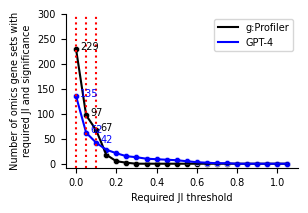

In [15]:
# plot thresholding curve
from utils.analyze_enrichment_utils import plot_thresholding_res
%reload_ext autoreload
%autoreload 2
save_plot_dir = 'data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_JI_curve.svg'
plot_thresholding_res(reduced_LLM_genes_by_apv_JI_DF, 'gprofiler_JI', 'LLM_JI',coverage_thresh_list = np.arange(0.0, 1.1, 0.05), enrich_adj_pval_thresh = adj_pval_thresh, LLM_score_thresh = LLM_score_thresh, highlight_coverage = [0.0, 0.05, 0.1], ax_label_keyword='JI')

# 5. Best JI of those meeting both JI and apv threshold
- Select the best GO term by the highest JI among the terms passing both the p-value and JI thresholds
 - Filter by both the p-value and JI thresholds to determine success vs not.

Yields the SAME numbers as option #4, but selects different GO terms 


In [6]:
from utils.analyze_enrichment_utils import filter_and_select_max_coverage
%reload_ext autoreload
%autoreload 2

grouped = merged_genes_DF.groupby(group_col)
reduced_LLM_genes_by_max_JI_DF = grouped.apply(lambda x:filter_and_select_max_coverage(x, adj_pval_thresh, 'gprofiler_JI', thresh=JI_thresh)).reset_index(drop=True)

# Add the 'LLM_success_TF' and 'gprofiler_success_TF' columns
reduced_LLM_genes_by_max_JI_DF['LLM_success_TF'] = ((reduced_LLM_genes_by_max_JI_DF['Score'] >= LLM_score_thresh)& (reduced_LLM_genes_by_max_JI_DF['LLM_JI'] >= JI_thresh)) # LLM creteria

reduced_LLM_genes_by_max_JI_DF['gprofiler_success_TF'] = ~((reduced_LLM_genes_by_max_JI_DF['Adjusted P-value'] > adj_pval_thresh) | (reduced_LLM_genes_by_max_JI_DF['gprofiler_JI'] < JI_thresh)) # enrichment criteria

print(create_success_contingency_table(reduced_LLM_genes_by_max_JI_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_by_max_JI_DF, 5)

result_df

LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                    22     45     67
False                   20    213    233
Total                   42    258    300


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,collagen metabolic process,GO:0032963,0.005761,4,101,"COL5A1,MMP2,VIM,CST3",0.181818,0.21,0.033613,False,False
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,inflammatory response,GO:0006954,0.001123,11,829,"1060P11.3,ADM,CAV2,CDC42EP3,EMP1,LPAR6,TRIB2,A...",0.250000,0.13,0.012761,False,False
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,actomyosin structure organization,GO:0031032,0.005933,6,204,"AKR1B1,CAPN3,DKK1,MARCKS,MTUS1,OPN3",0.113208,NaN,0.023904,False,False
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of oligodendrocyte apoptotic process,GO:1900141,0.000143,2,2,"GAS6,AKAP12",0.222222,NaN,0.222222,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,cellular response to interleukin-1,GO:0071347,0.000712,4,106,"H2AC6,IL1R2,NUP93,SOX9",0.285714,NaN,0.034483,False,False


In [12]:
## if the Terms are the same
sum(reduced_LLM_genes_by_apv_JI_DF['Term'] != reduced_LLM_genes_by_max_JI_DF['Term'])

60

## Computing semantic similarity of GO term name and LLM name when both methods yield a name

In [51]:
# load the semantic similarity
similarity_df = pd.read_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_only_simVals_DF.tsv", sep="\t")  
print(similarity_df.shape)
similarity_df.sort_values(by='LLM_name_GO_term_sim', ascending=False)

similarity_df = pd.merge(similarity_df, llm_ji_df, on=['Source','GeneSetID','GeneList','n_Genes', 'LLM Name','Supporting Count'], how='left')
print(similarity_df.shape)
print(similarity_df.columns)

# select both True and sort by similarity
similarity_df.loc[(similarity_df['LLM_success_TF'] == True) & (similarity_df['gprofiler_success_TF'] == True), :].sort_values(by='LLM_name_GO_term_sim', ascending=False).to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_only_llmT_enrichT_sort_simVals.tsv", sep="\t", index=False)
similarity_df.head(1)

(300, 26)
(300, 31)
Index(['Source', 'GeneSetID', 'GeneSetName', 'GeneList', 'updated GeneList',
       'n_Genes', 'LLM Name', 'LLM Analysis', 'Score', 'Term', 'GO ID',
       'Adjusted P-value', 'intersection_size', 'term_size', 'query_size',
       'intersections', 'gprofiler_JI', 'gprofiler_coverage',
       'Supporting Genes', 'Supporting Count', 'LLM Support Analysis',
       'GenesMentionedInText', 'LLM_coverage', 'LLM_success_TF',
       'gprofiler_success_TF', 'LLM_name_GO_term_sim', 'LLM_best_matching_GO',
       'best_matching_GO_ID', 'best_matching_GO_term_genes',
       'best_matching_GO_term_size', 'LLM_JI'],
      dtype='object')


,Source,GeneSetID,GeneSetName,GeneList,updated GeneList,n_Genes,LLM Name,LLM Analysis,Score,Term,...,GenesMentionedInText,LLM_coverage,LLM_success_TF,gprofiler_success_TF,LLM_name_GO_term_sim,LLM_best_matching_GO,best_matching_GO_ID,best_matching_GO_term_genes,best_matching_GO_term_size,LLM_JI
0,L1000,BRD-A00546892_-666_MCF7_6.0_h_10.0_um,BRD-A00546892 -666 MCF7 6.0 h 10.0 um,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,24,Cellular Matrix Remodeling and Tissue Development,"1. CITED2, TWIST1, and LMO2 are transcriptiona...",0.85,collagen metabolic process,...,24.0,0.21,True,True,0.620345,connective tissue development,GO:0061448,CRIP1 GDF5 IL17F MAF NOTCH1 AMELX VPS13B NFATC...,286.0,0.016181


(124, 31)


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


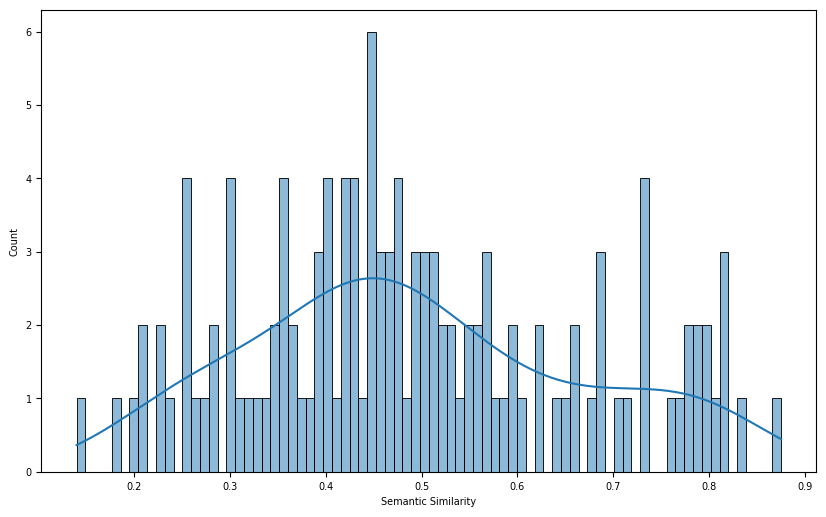

In [52]:
both_success = pd.read_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_only_llmT_enrichT_sort_simVals.tsv", sep="\t")  
print(both_success.shape)
# plot distribution of the similarity
plt.figure(figsize=(10, 6))
sns.histplot(data=both_success, x='LLM_name_GO_term_sim', bins=80, kde=True)
plt.xlabel('Semantic Similarity')
plt.ylabel('Count')
plt.show()

## Select the tails of the distribution

In [53]:
# cases above vs below the threshold
similarity_thre = 0.45
print(both_success[both_success['LLM_name_GO_term_sim'] > similarity_thre].shape[0])
print(both_success[both_success['LLM_name_GO_term_sim'] <= similarity_thre].shape[0])

69
55


## Compare p:Profiler coverage vs LLM coverage and show semantic similarity

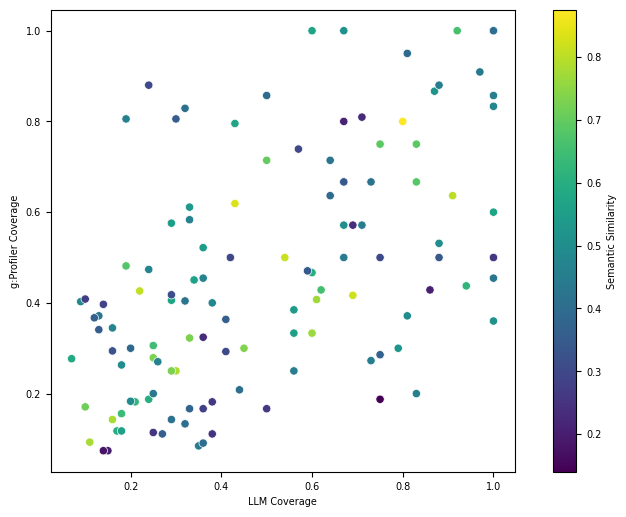

In [59]:
# LLM coverage vs gprofiler converage, colored by the similarity with countinuous color
plt.figure(figsize=(10, 6))

ax = sns.scatterplot(data=both_success, x='LLM_coverage', y='gprofiler_coverage', hue='LLM_name_GO_term_sim', palette='viridis',legend=None)

plt.xlabel('LLM Coverage')
plt.ylabel('g:Profiler Coverage')

# Setting the aspect of the plot to be equal
ax.set_aspect('equal', adjustable='box')

# Create a colorbar
norm = plt.Normalize(both_success['LLM_name_GO_term_sim'].min(), both_success['LLM_name_GO_term_sim'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

plt.colorbar(sm, ax=ax, label='Semantic Similarity')

plt.show()



## Compare p:Profiler JI vs LLM JI and show semantic similarity

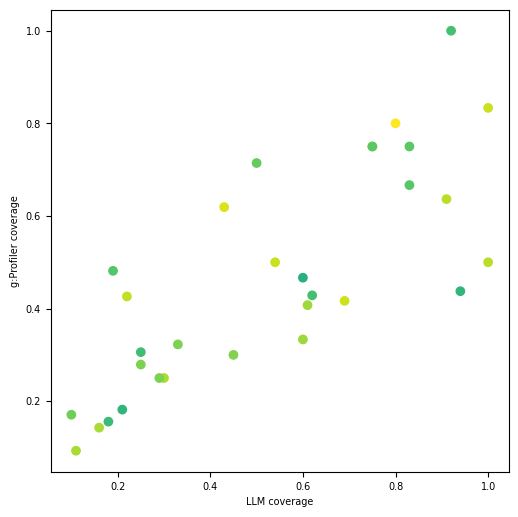

In [72]:


# Define the range of semantic similarity you're interested in
similarity_min = 0.6
similarity_max = 0.99

# y_field = 'gprofiler_JI'
# y_label = 'g:Profiler JI'
# x_field = 'LLM_JI'
# x_label = 'LLM JI'

y_field = 'gprofiler_coverage'
y_label = 'g:Profiler coverage'
x_field = 'LLM_coverage'
x_label = 'LLM coverage'

# Filter the DataFrame
filtered_data = both_success[(both_success['LLM_name_GO_term_sim'] >= similarity_min) &
                             (both_success['LLM_name_GO_term_sim'] <= similarity_max)]

# LLM JI vs gprofiler JI, colored by the similarity with countinuous color
plt.figure(figsize=(10, 6))

# Full range normalization
full_range_norm = plt.Normalize(both_success['LLM_name_GO_term_sim'].min(), both_success['LLM_name_GO_term_sim'].max())

# Create the scatter plot using the filtered data with explicit normalization
# Here, we switch to using matplotlib directly
sc = plt.scatter(
    x=filtered_data[x_field], 
    y=filtered_data[y_field], 
    c=filtered_data['LLM_name_GO_term_sim'],  # Color by this column
    cmap='viridis',
    norm=full_range_norm  # Explicitly use the full range for color normalization
)

plt.xlabel(x_label)
plt.ylabel(y_label)

# Setting the aspect of the plot to be equal
plt.gca().set_aspect('equal', adjustable='box')


# Create a colorbar
#norm = plt.Normalize(both_success['LLM_name_GO_term_sim'].min(), both_success['LLM_name_GO_term_sim'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=full_range_norm)
sm.set_array([])

plt.colorbar(sm, ax=ax, label='Semantic Similarity')

plt.show()

In [55]:
both_success.loc[(both_success['LLM_name_GO_term_sim'] < similarity_thre), ['n_Genes', 'GeneList', 'LLM Name', 'Score', 'Term', 'GO ID','LLM_name_GO_term_sim',
        'Adjusted P-value', 'intersection_size', 'term_size', 'intersections',  'gprofiler_coverage','LLM_coverage', 'gprofiler_JI', 'LLM_JI',
        'LLM_success_TF', 'gprofiler_success_TF']].sort_values(by='LLM_name_GO_term_sim', ascending=True)

,n_Genes,GeneList,LLM Name,Score,Term,GO ID,LLM_name_GO_term_sim,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_JI,LLM_success_TF,gprofiler_success_TF
123,16,ANKRD39 BTBD9 KCTD9 KCTD11 KLHL2 KLHL3 KLHL12 ...,Regulation of Cullin-RING Ubiquitin Ligase (CR...,0.85,negative regulation of pancreatic juice secretion,GO:0090188,0.140170,3.053437e-06,3,5,"WNK1,WNK3,WNK4",0.187500,0.75,0.166667,0.600000,True,True
122,29,1060P11.3 AEBP1 AMIGO2 CNPY3 FABP7 HMGCR HMGCS...,Cholesterol Biosynthesis and Regulation,0.85,positive regulation of aggrephagy,GO:1905337,0.179547,3.135453e-03,2,3,"APLP2,FERMT1",0.074074,0.14,0.071429,0.083333,True,True
121,7,AK2 CDH1 HADHA HADHB MT-ATP8 MT-ND4L SQSTM1,Mitochondrial Energy Metabolism and Cellular A...,0.85,ribonucleotide biosynthetic process,GO:0009260,0.203701,3.546188e-03,3,231,"AK2,MT-ATP8,MT-ND4L",0.428571,0.86,0.012766,0.057143,True,True
120,27,CHEK1 DAB2 EGLN3 MFAP5 MXRA5 PDCD4 PLEKHM1 PTP...,Cellular Stress Response and Apoptosis Regulation,0.85,fructose biosynthetic process,GO:0046370,0.205950,2.612569e-03,2,2,"AKR1B1,SORD",0.074074,0.15,0.074074,0.005961,True,True
119,21,AR CARM1 COPS2 CREBBP E2F1 EP300 HDAC2 HDAC3 H...,Chromatin remodeling and transcriptional regul...,0.92,negative regulation of nucleobase-containing c...,GO:0045934,0.210030,4.266629e-12,16,1588,"AR,COPS2,CREBBP,E2F1,EP300,HDAC2,HDAC3,H3C1,LC...",0.800000,0.67,0.010050,0.021374,True,True
118,21,ATXN3 CCNA2 CHEK2 COPS5 CREBBP CTNNB1 EP300 HD...,Chromatin remodeling and transcriptional regul...,0.92,positive regulation of RNA biosynthetic process,GO:1902680,0.227990,1.161495e-12,17,1706,"CCNA2,CHEK2,COPS5,CREBBP,CTNNB1,EP300,HDAC2,HD...",0.809524,0.71,0.009942,0.022901,True,True
117,39,ABHD4 ACKR3 ANPEP BEX1 CXCL8 CYP1A1 CYP1B1 DHR...,Cellular Stress Response and Detoxification,0.87,blood vessel development,GO:0001568,0.229752,2.729563e-06,12,721,"ACKR3,ANPEP,CXCL8,CYP1B1,FOSL1,GADD45A,ADGRG1,...",0.324324,0.36,0.016086,0.092105,True,True
116,16,ATF1 ATF4 BATF CEBPG CLIP1 CREB1 CREM DDIT3 GA...,Cellular Stress Response and Gene Expression R...,0.92,positive regulation of RNA biosynthetic process,GO:1902680,0.234263,6.218248e-04,8,1706,"ATF1,ATF4,BATF,CEBPG,CREB1,CREM,JDP2,POU6F1",0.571429,0.69,0.004673,0.016641,True,True
115,40,1060P11.3 BEX1 CD44 CDC42EP3 CHI3L1 EXT1 IGFBP...,Tumor Microenvironment Modulation and Extracel...,0.85,animal organ formation,GO:0048645,0.252990,4.036170e-03,4,70,"CHI3L1,VCAN,DDX3Y,MSRB2",0.114286,0.25,0.039604,0.100000,True,True
114,55,BTN2A1 BTN2A2 C2CD2 C3orf58 CCL1 CD70 CLEC2B C...,Immune System Modulation and Inflammation,0.85,B cell proliferation,GO:0042100,0.254791,1.321903e-03,5,105,"CCL1,IFITM2,MANSC1,TNFAIP8,TNFRSF13B",0.111111,0.38,0.034483,0.013672,True,True
